In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings  
warnings.filterwarnings("ignore") 

In [2]:
# Function for plotting box grpahs
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default',y=column, data=train,ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [3]:
RANDOM_SEED = 420

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.info()
# As we can see NaNs are only in one column 'education'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
test.info()
# The same for test df, 'education' is an only column that has NaNs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Text(0.5, 1.0, 'Boxplot for education train')

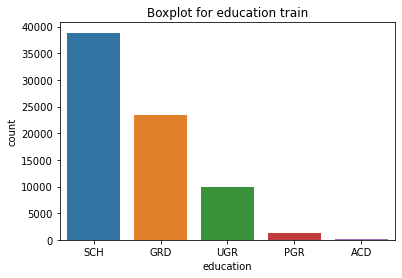

In [7]:
# Let's see what is the most common value for education in our train dataset
fig = sns.countplot(train['education'])
fig.set_title('Boxplot for education train')

Text(0.5, 1.0, 'Boxplot for education test')

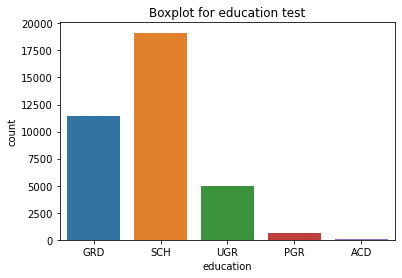

In [8]:
# Let's also see the same for test dataset
fig = sns.countplot(test['education'])
fig.set_title('Boxplot for education test')

------------------------EDA------------------------

In [9]:
# Based on above i could simply fill the NaN values with a constant value, but i decided to improve filling NaN values approach
# Based on the below code, the loop fills the NaN value with its most suitable education type based on a few criterias,
# In case if there is no even a match it fills with the constant
for index, row in train[train.education.isnull()].iterrows():
    a = train['education'][(train.age == row[5]) & (train.sex == row[4]) & (train.car == row[6]) & (train.car_type == row[7]) & (train.decline_app_cnt == row[8]) & 
       (train.good_work == row[9]) & (train.bki_request_cnt == row[11])  & (train.income == row[15])].value_counts() # looks for the same info
    if len(a) != 0: # if value_counts is not empty then it fills with its #1 value
        train['education'][index] = a.index[0]
    else: # else fills it with the most common value
        train['education'][index] = 'SCH'

for index, row in test[test.education.isnull()].iterrows():
    a = test['education'][(test.age == row[5]) & (test.sex == row[4]) & (test.car == row[6]) & (test.car_type == row[7]) & (test.decline_app_cnt == row[8]) & 
       (test.good_work == row[9]) & (test.bki_request_cnt == row[11])  & (test.income == row[15])].value_counts() # looks for the same info
    if len(a) != 0: # if value_counts is not empty then it fills with its #1 value
        test['education'][index] = a.index[0]
    else: # else fills it with the most common value
        test['education'][index] = 'SCH'

In [10]:
# the remaining app_date should be converted to timestamp
train['app_date'] = pd.to_datetime(train['app_date'])
test['app_date'] = pd.to_datetime(test['app_date'])
# The lists will help us with plotting graphs or analyzing numerical, binary or categorial values.
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'work_address', 'home_address', 'sna','first_time','app_date']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

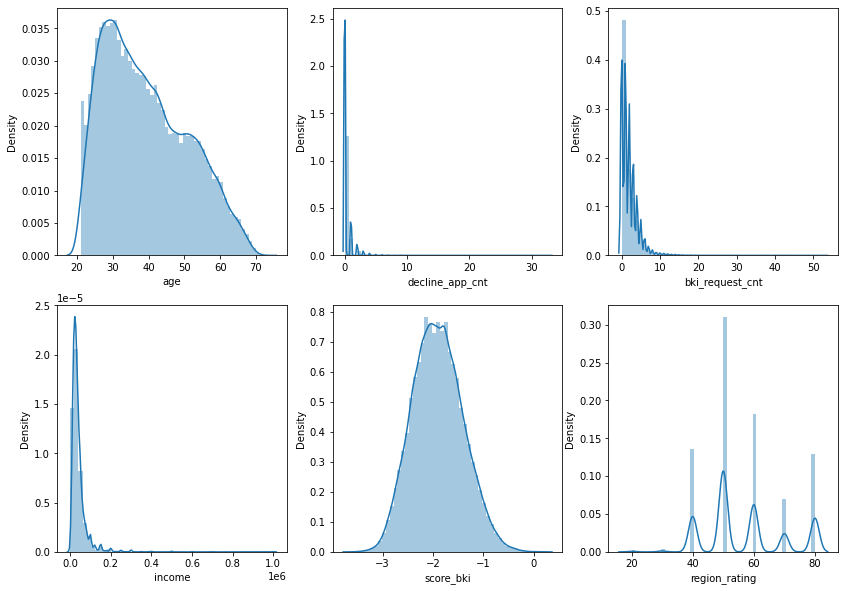

In [11]:
# Distribution of numerical values
a,b,c = 2,3,1
fig = plt.figure(figsize=(14,10))
for col in num_cols:
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.distplot(train[col])
    c = c + 1
plt.show()
# decline_app_cnt, bki_requests_cnt, income are strongly skweed to the left. lets apply log function

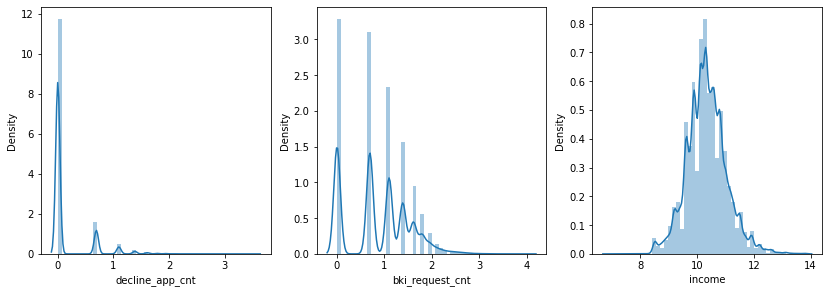

In [12]:
a,b,c = 2,3,1
fig = plt.figure(figsize=(14,10))
for col in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.distplot(np.log(train[col]+1))
    c = c + 1
plt.show()
# Now the distribution is a bit more normal for cnt type columns but still not the best, meantime income is distributed normally

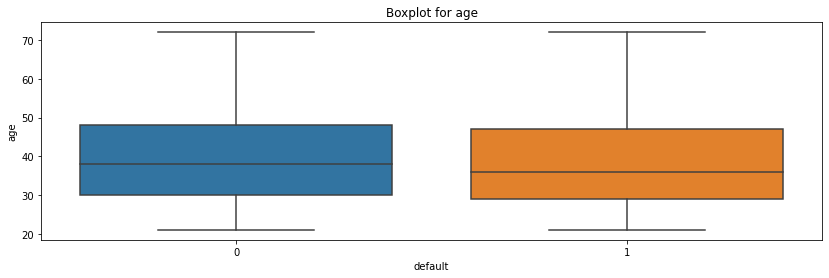

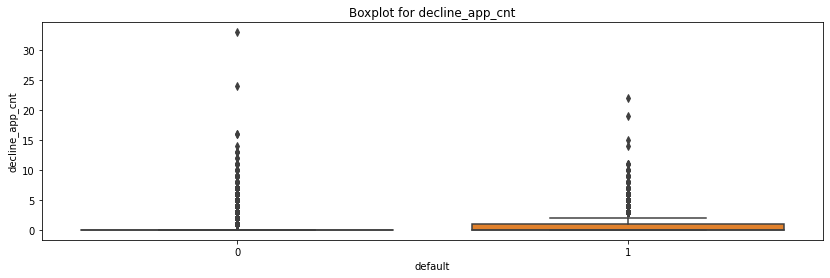

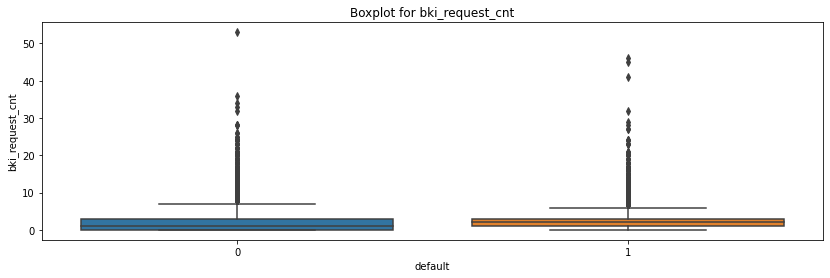

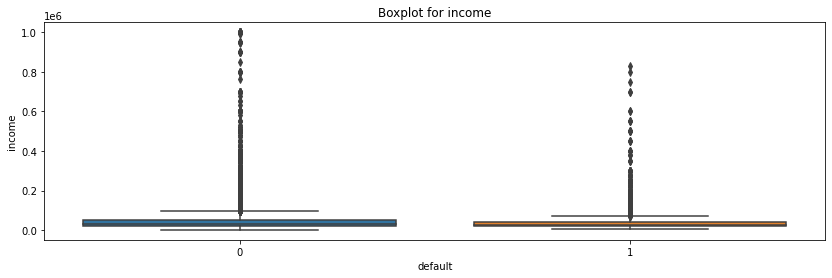

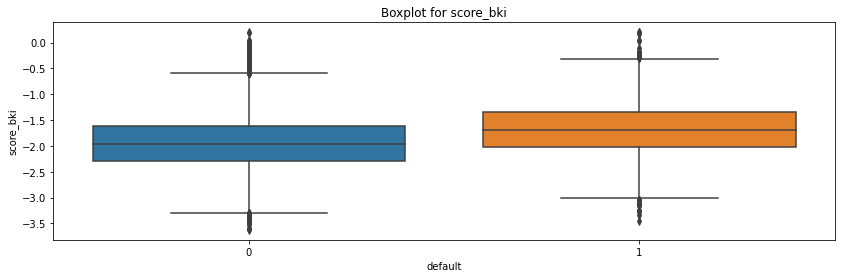

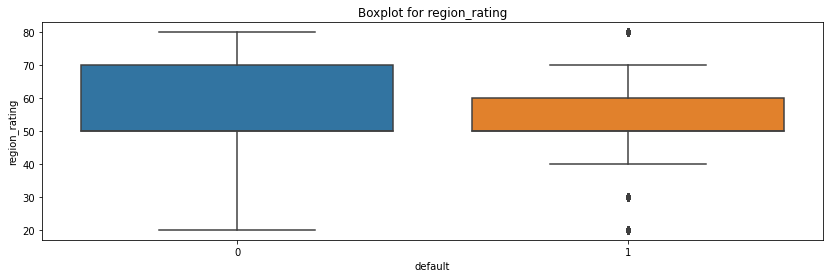

In [13]:
for i in num_cols:
    get_boxplot(i)

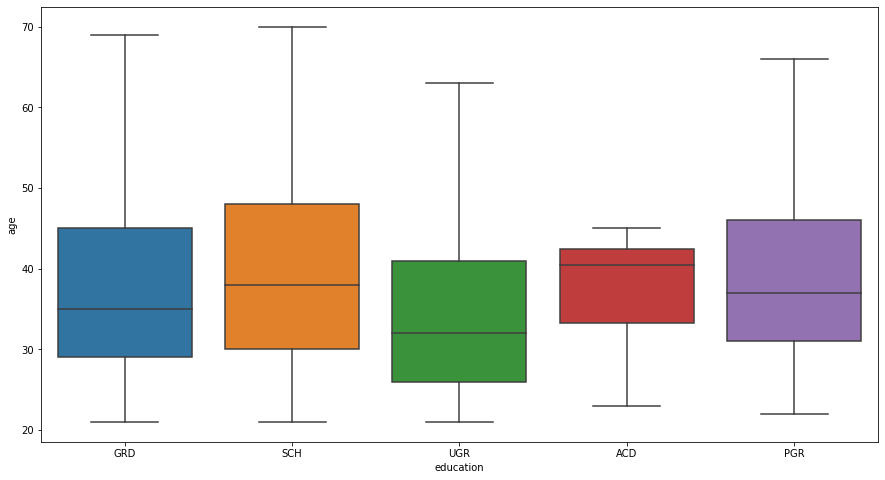

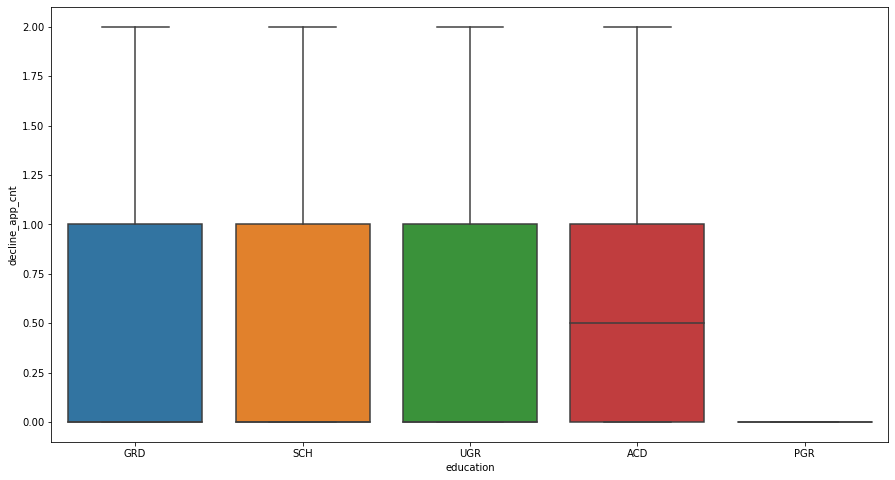

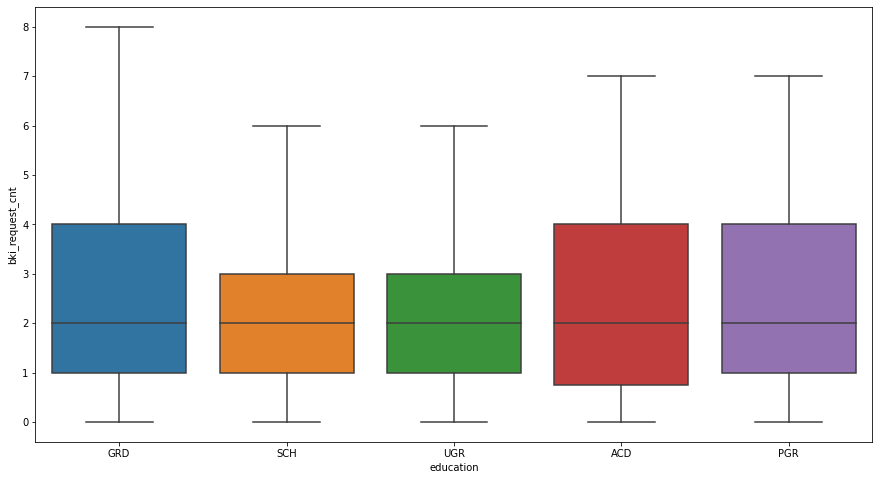

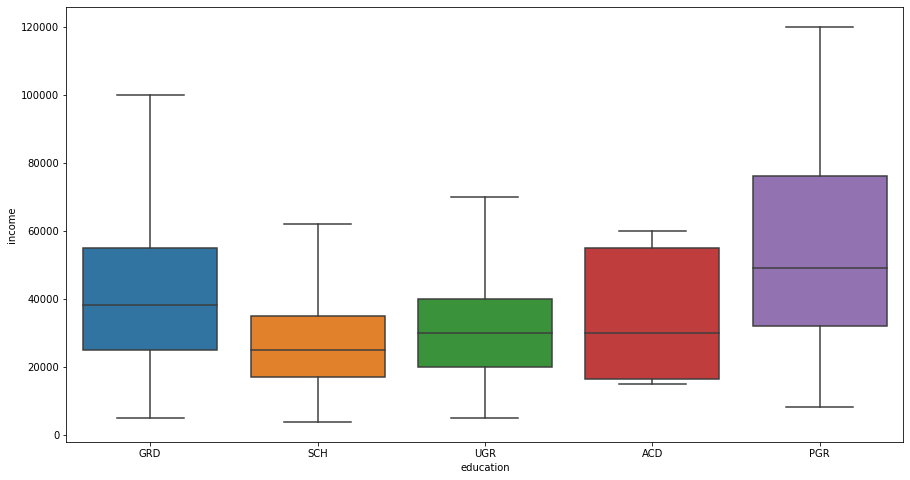

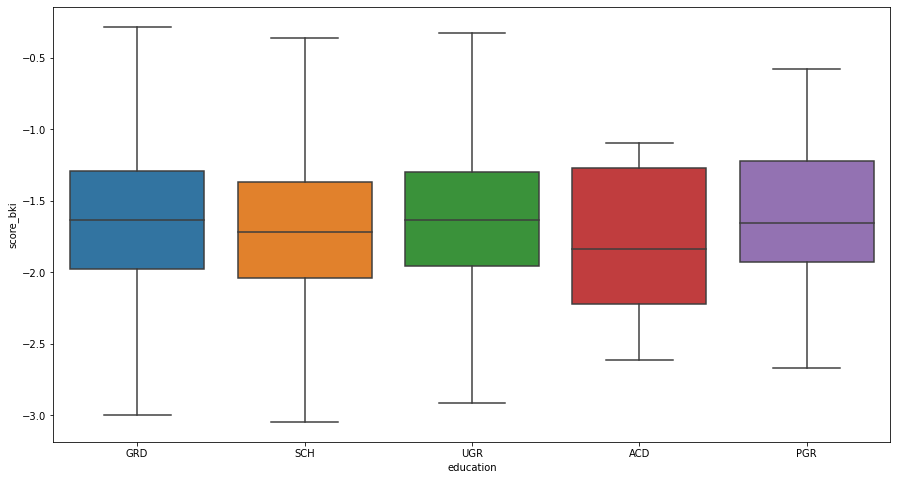

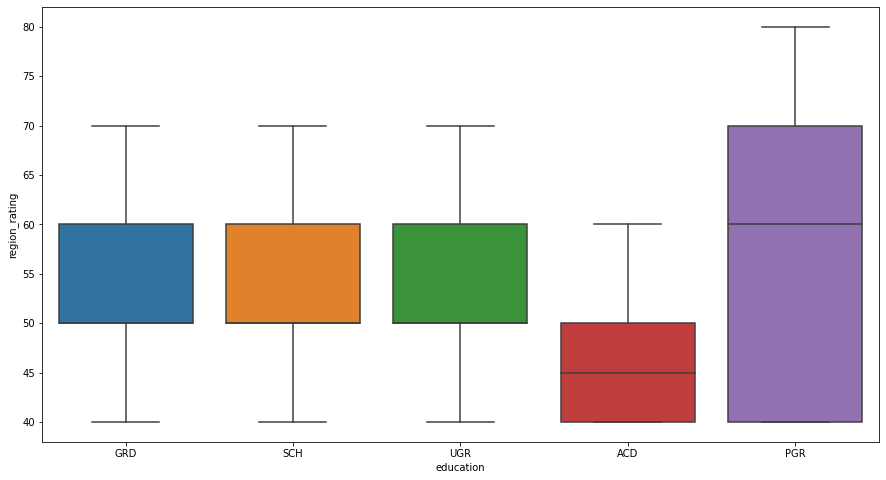

In [14]:
# Coorelation for each numerical value with education
for i in num_cols:
    plt.figure(figsize=(15, 8))
    sns.boxplot(x="education", y=i, data=train[train.default == 1], showfliers=False)
# age does not tell us anyting, value are almost equal
# decline_app_cnt nothing
# bki_requests_cnt nothing
# People with education ACD are generally earning more
# score_bki are queal to each other
# people with SCH, GRD, UGR are more stable in terms of region_rating and education

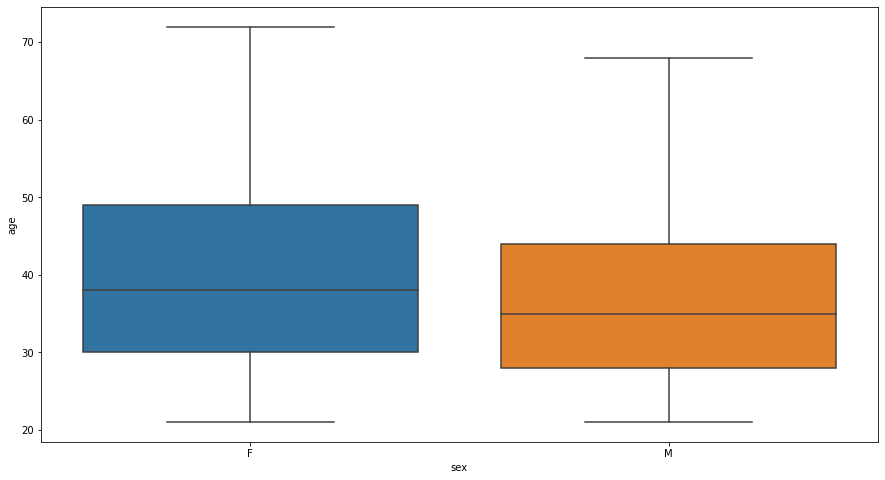

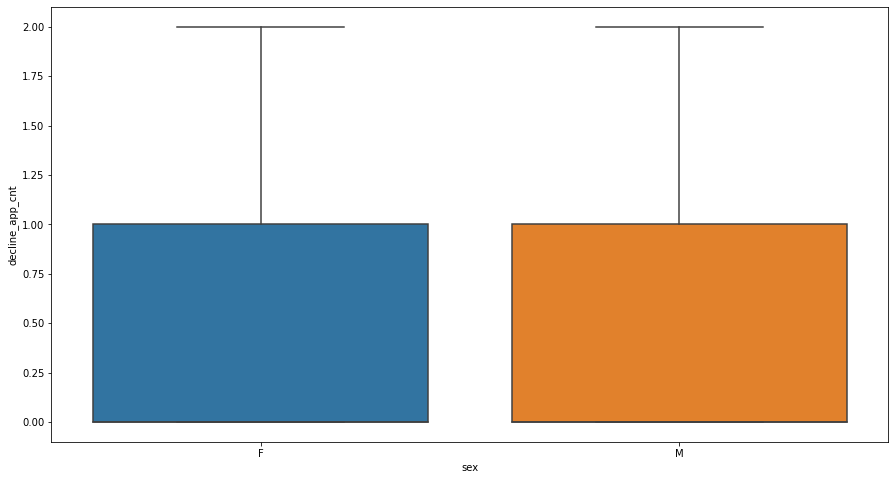

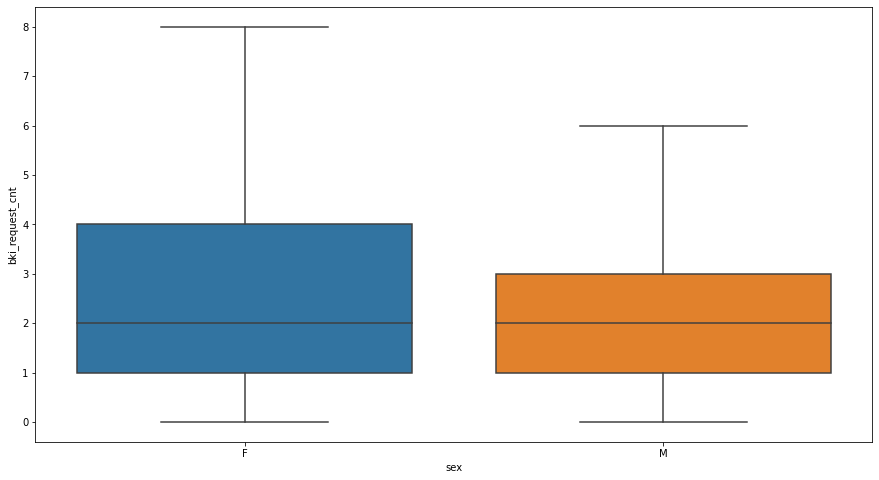

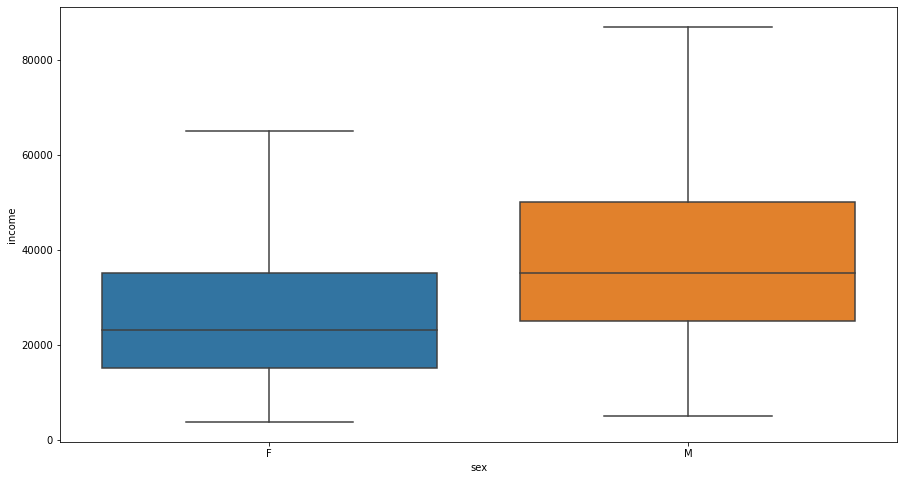

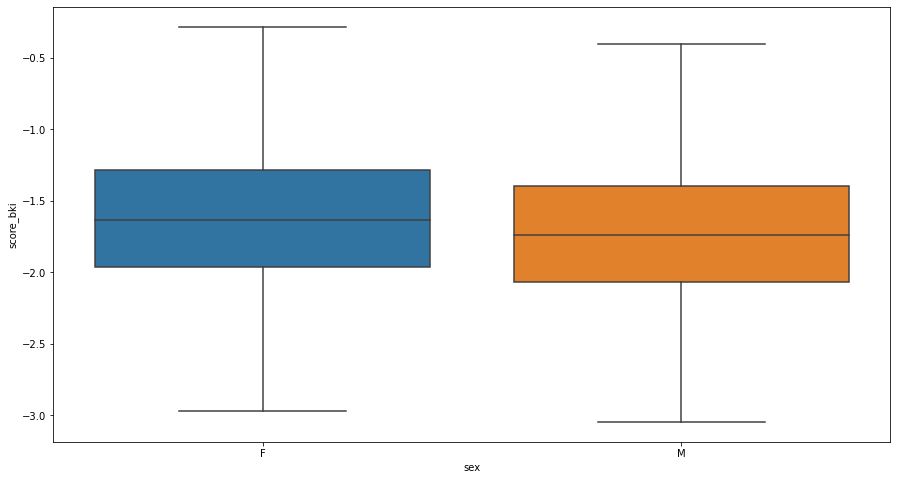

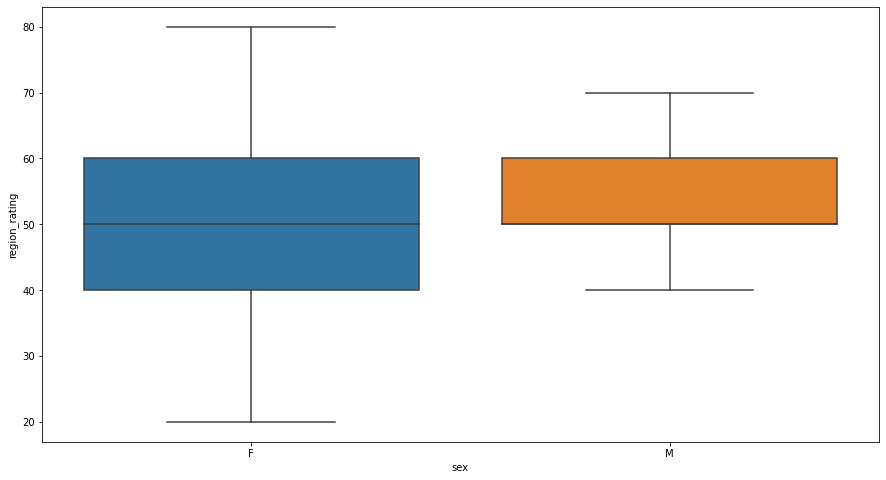

In [15]:
for i in num_cols:
    plt.figure(figsize=(15, 8))
    sns.boxplot(x="sex", y=i, data=train[train.default == 1], showfliers=False)
# Amomg default clients males are generally younger
# Females genraly have more bki requests
# Males are earning more than womens
# Womens have better score_bki 
# Males are generally have better region rating

<AxesSubplot:>

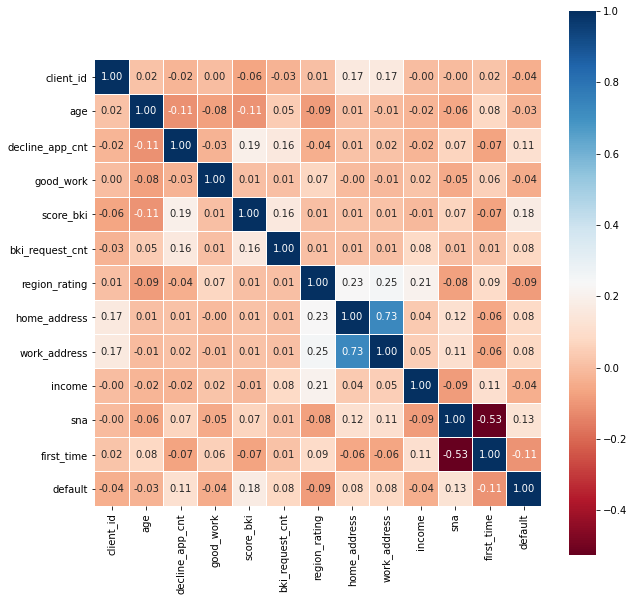

In [16]:
plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), square=True,
              annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")
# no strong coorelation, except home address and work address

------------------------FEATURE ENGINEERING------------------------

In [17]:
# Converting date to dayofweek
test['app_date'] = train.app_date.dt.dayofweek
train['app_date'] = train.app_date.dt.dayofweek

In [18]:
# mean income by age 
mean_income = train.groupby('age')['income'].mean().to_dict()
train['mean_age_income'] = train['age'].map(mean_income)
mean_income = test.groupby('age')['income'].mean().to_dict()
test['mean_age_income'] = test['age'].map(mean_income)

In [19]:
# mean income by region
mean_region_income = train.groupby('region_rating')['income'].mean().to_dict()
train['mean_region_income'] = train['region_rating'].map(mean_region_income)
mean_region_income = test.groupby('region_rating')['income'].mean().to_dict()
test['mean_region_income'] = test['region_rating'].map(mean_region_income)

In [20]:
# mean bki score by age income
mean_age_scorebki = train.groupby('mean_age_income')['score_bki'].mean().to_dict()
train['mean_age_scorebki'] = train['mean_age_income'].map(mean_age_scorebki)
mean_age_scorebki = test.groupby('mean_age_income')['score_bki'].mean().to_dict()
test['mean_age_scorebki'] = test['mean_age_income'].map(mean_age_scorebki)

In [21]:
# mean bki score by region rating
mean_region_scorebki = train.groupby('region_rating')['score_bki'].mean().to_dict()
train['mean_region_scorebki'] = train['region_rating'].map(mean_region_scorebki)
mean_region_scorebki = test.groupby('region_rating')['score_bki'].mean().to_dict()
test['mean_region_scorebki'] = test['region_rating'].map(mean_region_scorebki)

In [22]:
# adding new features to the list
num_cols.append('mean_age_income')
num_cols.append('mean_region_income')
num_cols.append('mean_age_scorebki')
num_cols.append('mean_region_scorebki')

------------------------MODELING------------------------

<AxesSubplot:>

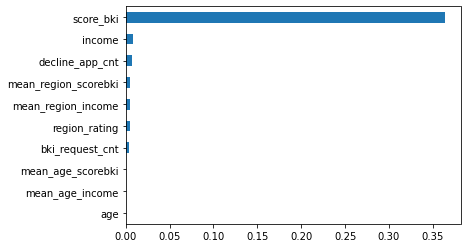

In [23]:
# importance of numerical values
imp_num = Series(mutual_info_classif(train[num_cols], train['default'],
                                     discrete_features =True), index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [24]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])

In [25]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
Y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

<AxesSubplot:>

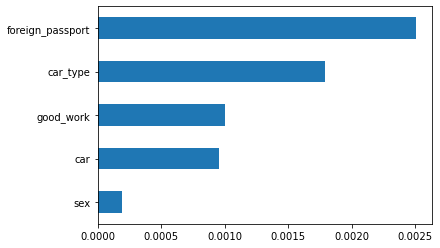

In [26]:
# Importance of binary values
imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

In [27]:
X_num = StandardScaler().fit_transform(train[num_cols].values)
Y_num = StandardScaler().fit_transform(test[num_cols].values)

In [28]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, Y_cat])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [30]:
# looking for the best C
from sklearn.model_selection import GridSearchCV
model = LogisticRegression(random_state=42, max_iter=5000)
C = np.logspace(0, 4, 10)
param_grid = [
    {'penalty': ['l2'], 
     'solver': ['lbfgs', 'liblinear'],
    'C': C}
]
gridsearch = GridSearchCV(model, param_grid, cv=5, verbose=0)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# best scores
best_parameters = model.get_params()
best_parameters

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [38]:
# Build model
model = LogisticRegression(
    C=1,
    class_weight = None,
    dual = False,
    fit_intercept = True,
    intercept_scaling= 1,
    l1_ratio = None,
    max_iter = 5000,
    multi_class = 'auto',
    n_jobs = None,
    penalty = 'l2',
    random_state = 42,
    solver = 'lbfgs',
    tol = 0.0001,
    verbose = 0,
    warm_start = False
)

model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000, random_state=42)

In [39]:
Y_predict = model.predict(X_test)
Y_predict_prob = model.predict_proba(X_test)[:,1]

In [40]:
y_pred_test = model.predict(test)
y_pred_prob_test = model.predict_proba(test)[:,1]

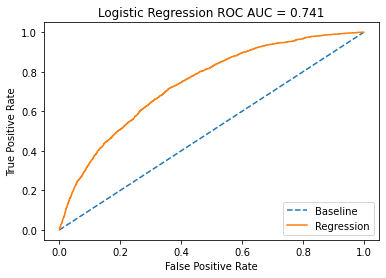

In [41]:
fpr, tpr, threshold = roc_curve(y_test, Y_predict_prob)
roc_auc = roc_auc_score(y_test, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [42]:
main_model = LogisticRegression( 
    C=1,
    class_weight = None,
    dual = False,
    fit_intercept = True,
    intercept_scaling= 1,
    l1_ratio = None,
    max_iter = 5000,
    multi_class = 'auto',
    n_jobs = None,
    penalty = 'l2',
    random_state = 42,
    solver = 'lbfgs',
    tol = 0.0001,
    verbose = 0,
    warm_start = False
)
main_model.fit(X, Y)

# Predict values based on test data
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

In [43]:
new_sample_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred_prob_test})
new_sample_submission.to_csv('submission.csv', index=False)

new_sample_submission.head(10)

,client_id,default
0,74835,0.040616
1,17527,0.341108
2,75683,0.071302
3,26883,0.077160
4,28862,0.023844
5,99881,0.180648
6,26630,0.298137
7,79934,0.034606
8,16605,0.021078
9,105449,0.033013


In [44]:
new_sample_submission.shape

(36349, 2)